> # <center> Data-jutsu 🥷: Unraveling Anime’s Hidden Storylines <center/>

<div style="text-align: center; padding: 20px;"> 

<h2> Introduction <img src='https://i.imgur.com/45u09oc.png' width=50 padding=1></h2>
</div>


<br> ----- </br>

Anime ( Japanese Animation) is a global cultural phenomenon loved for its imaginative narratives, visual artistry, and passionate fanbase.<br></br>
<div style='text-align: center; padding: 20px;'>

<img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExa3EybHhoMTFtdnkxY2h4N29lNXBndWpxemp3OWZkaWRtbWVhNHc3YyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3MC3bRtiRDIaGEVV7Y/giphy.gif" alt="Alt Text" width=700>
</div>



### 🔴**Project objectives** :  

This project will try to analyze
the diverse tastes and preferences of The average anime enthusiasts by analyzing multiple datasets and exploring the relationship between **genres**, **ratings**,**Age**, and **gender** demographics. which evanusally would help to explore the detailed world of anime fans and discover interesting things about  people who love watching anime.

>💡This notebook serves as the first part of our analysis, focusing on diving into anime-related data. In contrast, the next section,User Analysis Notebook, will be all about exploring how users interact with **MyAnimeList**. There, we'll look into things like who these users are, what they like, and how they engage with the website. Together, these sections aim to give us a complete understanding of the anime fandom.

The analysis will try to ask questions as :

- 1. What is the average anime fan Age ?
- 2. what is the perfered genre for males and females respectivly ?
- 3. what are the top 10 rated animes ?
- 4. anime shows vs Movies , which is streamed more?
- 5. how much does the average anime fan spend watching anime (Days)?
- 6. is Genre related to score ? and if so , how ?

<br> </br>


### 📌**Data Source:**
[`anime-dataset.csv` `anime-filtered.csv`]

- 📃**Description**: This dataset available on Kaggle contains information from [MyAnimeList](https://myanimelist.net), a popular anime and manga community platform. It encompasses details about anime, including titles, genres, ratings, episodes, and more.



- 🔗**Link**: MyAnimeList Dataset on [Kaggle](https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset)






>### <center> Import Required Libraries 📥 <center/>

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from datetime import datetime
import logging
import warnings


from scipy.stats import pearsonr

from sklearn.impute import KNNImputer
import os
import dask.dataframe as dd
from cycler import cycler



%matplotlib inline
plt.style.use('code/dark.mplstyle')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

>### <center> ⚙️Helper Functions</center>
 <center> Writing functions to simplify certain repetitive tasks.<center\>

In [43]:
# A FUNCTION TO REPLACE "UNKNOWN" VALUES WITH NAN .
def clean_column(column):
    column = pd.to_numeric(column, errors='coerce')
    column = column.replace('UNKNOWN', np.nan)
    column.fillna(column.mean(), inplace=True)
    return column

# A FUNCTION TO READ THE DATA FROM CSV FILE INTO CHUNKS AND RETURN A DATAFRAME .
def read_csv_to_chunks(file_path, chunk_size):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Process the chunk or append it directly to the list
        chunks.append(chunk)
    return pd.concat(chunks)

# A FUNCTION TO CLEAN THE BIRTHDAY COLUMN , AND EXTRACT THE YEAR.
def adjust_year(year):
    if year.startswith('00'):
        return '20' + year[2:]
    if year.startswith('99'):
        return '19' + year[2:]
    return year

# AFTER EXTRACTING THE YEAR , THIS FUNCTION WILL CALCULATE THE USER'S AGE 
def calculate_age(birthdate_str):
    birthdate_str = str(birthdate_str)  # Ensure it's a string
    birthdate = pd.to_datetime(birthdate_str, errors='coerce')
    #print(birthdate)
    default_date = pd.to_datetime('1900-01-01')

    # Check for NaT values
    if pd.isnull(birthdate):
        return None  # Return None for NaT values

    # Extract year, month, and day
    birth_year = birthdate.year
    birth_month = birthdate.month
    birth_day = birthdate.day

    # Handle problematic entries
    if birth_year < 1900:
        birth_year += 1900
    else:
        birth_year = int(adjust_year(str(birth_year)))

    # Create a new datetime object
    adjusted_birthdate = datetime(birth_year, birth_month, birth_day)

    # Get the current date
    current_date = datetime.now()

    # Calculate age
    age = current_date.year - adjusted_birthdate.year - ((current_date.month, current_date.day) < (adjusted_birthdate.month, adjusted_birthdate.day))
    return age

# A FORMATTER FUNCTION TO CUSTOMIZE THE Y-AXIS TICKS .
def dynamic_formatter(x, pos):
    magnitude = 0
    while abs(x) >= 1000:
        magnitude += 1
        x /= 1000.0
    return '{:.0f}{}'.format(x, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

# ANOTHER FORMATTER TO HANDLE VALUES LIKE MILLIONS AND ABOVE 
def million_formatter(x, pos):
    if x == 0:
        return '0'
    elif x >= 1000000:
        return '{:.1f}M'.format(x / 1000000)
    else:
        return '{:.0f}K'.format(x / 1000)

# A LIST CONTAINING THE FILE PATHS FOR OUR CSV FILES 
file_path = ['CSV/anime-dataset-2023.csv' , 'CSV/anime-filtered.csv']


>### <center>🛠️Load & Clean Data</center>

**<center>  Loading the Dataset <center/>**
 
- ###### Since we are dealing with 100000s of rows , The csv files containg the data will be read into 1000 chunks at a time for memory effeciancy 
- ###### Then , the 2 data sets will be converted to a pandas dataframe for further processing 
- ###### We will inspect the two daaframes by printing the `head()` (first 5 rows of the Dataframe)

In [44]:
chunk_size = 1000  # Specify the number of rows to read at a time

anime1 = read_csv_to_chunks(file_path[0], chunk_size)
anime1.shape
anime1.head()


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [45]:
anime2 = read_csv_to_chunks(file_path[1], 100)
anime2.head(5)


,anime_id,Name,Score,Genres,English name,Japanese name,sypnopsis,Type,Episodes,Aired,...,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,"In the year 2071, humanity has colonized sever...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,"other day, another bounty—such is the life of ...",Movie,1,"Sep 1, 2001",...,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,"Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),ches are individuals with special powers like ...,TV,26,"Jul 2, 2002 to Dec 24, 2002",...,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108


><center> Merging Data & removing uneccesary columns <center\>

💡Let's simplify our data merging process.  Below ⬇️ , we have two CSV files, each containing different columns of anime data. We need to combine them into one DataFrame, making sure to only include columns that are common to both files. This way, we'll create a unified dataset with all relevant information.

In [46]:
filtered_cols = ['Watching', 'Completed', 'On-Hold', 'Dropped', 'Type']
filtered_cols

#dropping duplicated column [Type]
anime1.drop(columns=['Type'], inplace=True)

#check if the column still exisits
print(f'anime1 columns : {anime1.columns}')

# Adding each column in [filtered_cols] from anime2 to anime1 
for col in filtered_cols:
    anime1[col] = anime2[col]

# create the new unifed dataframe anime:
anime = anime1


anime1 columns : Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Episodes', 'Aired', 'Premiered', 'Status', 'Producers',
       'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Rank',
       'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL'],
      dtype='object')


><center> Inspecting The Data <center\> 
a quick statics summary will be performed to inspect the data's (Shape, number of values , Mean , number of Null values , distribution)

In [47]:
print(f'DESCRIBE ANIME DATAFRAME\n: {anime.describe(include='all')}' , '\n')

DESCRIBE ANIME DATAFRAME
:             anime_id       Name English name Other name    Score   Genres  \
count   24905.000000      24905        24905      24905    24905    24905   
unique           NaN      24901        10134      23796      866     1006   
top              NaN  Azur Lane      UNKNOWN    UNKNOWN  UNKNOWN  UNKNOWN   
freq             NaN          2        14577        128     9213     4929   
mean    29776.709014        NaN          NaN        NaN      NaN      NaN   
std     17976.076290        NaN          NaN        NaN      NaN      NaN   
min         1.000000        NaN          NaN        NaN      NaN      NaN   
25%     10507.000000        NaN          NaN        NaN      NaN      NaN   
50%     34628.000000        NaN          NaN        NaN      NaN      NaN   
75%     45240.000000        NaN          NaN        NaN      NaN      NaN   
max     55735.000000        NaN          NaN        NaN      NaN      NaN   

                                        Synopsis

In [48]:
print(f'DATA SHAPE:\n {anime.shape}')

DATA SHAPE:
 (24905, 28)


📍We notice the presence of  values such as **"Unknown" ,"No describtion available for this anime "** , **"Not Available"** along with other null values .

In [49]:
print(anime.dtypes)

anime_id          int64
Name             object
English name     object
Other name       object
Score            object
Genres           object
Synopsis         object
Episodes         object
Aired            object
Premiered        object
Status           object
Producers        object
Licensors        object
Studios          object
Source           object
Duration         object
Rating           object
Rank             object
Popularity        int64
Favorites         int64
Scored By        object
Members           int64
Image URL        object
Watching        float64
Completed       float64
On-Hold         float64
Dropped         float64
Type             object
dtype: object


There is also inconsistency in most of the columns Datatypes. For example, columns such as `Duration : object` , when it should be `Duration : int` and `Score : object` instead of `Score : float` 

To help clean the data, we will inspect the exact number of null values in the dataset ⬇️:

In [50]:
print(f'NULL VALUES:\n {anime.isnull().sum()}')
anime.head()

NULL VALUES:
 anime_id           0
Name               0
English name       0
Other name         0
Score              0
Genres             0
Synopsis           0
Episodes           0
Aired              0
Premiered          0
Status             0
Producers          0
Licensors          0
Studios            0
Source             0
Duration           0
Rating             0
Rank               0
Popularity         0
Favorites          0
Scored By          0
Members            0
Image URL          0
Watching        9953
Completed       9953
On-Hold         9953
Dropped         9953
Type            9953
dtype: int64


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Episodes,Aired,Premiered,...,Popularity,Favorites,Scored By,Members,Image URL,Watching,Completed,On-Hold,Dropped,Type
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",26.0,"Apr 3, 1998 to Apr 24, 1999",spring 1998,...,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...,105808.0,718161.0,71513.0,26678.0,TV
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",1.0,"Sep 1, 2001",UNKNOWN,...,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...,4143.0,208333.0,1935.0,770.0,Movie
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",26.0,"Apr 1, 1998 to Sep 30, 1998",spring 1998,...,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...,29113.0,343492.0,25465.0,13925.0,TV
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,26.0,"Jul 3, 2002 to Dec 25, 2002",summer 2002,...,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...,4300.0,46165.0,5121.0,5378.0,TV
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,52.0,"Sep 30, 2004 to Sep 29, 2005",fall 2004,...,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...,642.0,7314.0,766.0,1108.0,TV


><center>🔎After inspecting the data, the following observations were made :<center\>

- ###### <center> The data has a total of 24905 rows and  28 columns <center/>
-  ###### <center> The top value in these columns [English name, Other name, Score , Genres] is "UNKNOWN" <center/>
- ###### <center> While the top value in [Synopsis, Aired] are " No description available for this anime." and , "Not available " <center/>

- ###### <center> After analyzing the missingness patterns in the dataset, It has been identified that  the missingness type is determined to be MCAR." <center/>

- ###### <center> The datatypes are inconsistent . <center/>


---

>### <center>  🧹Cleaning  & tidying Data <center/>

<center>After detecting all problematic issues in the dataset , The cleaning process will be executed by handling missing values and fixing Datatypes  <center/>

- Handle invalid values ['UNKNOWN', 'Not Available' , ' No description available for this anime.']

In [51]:
# REPLCAE 'UNKNOWN' WITH NP.NAN , THEN IMPUTE THE NAN VALUES WITH THE MEAN VALUE . 
anime[['Rank', 'Score', 'Scored By', 'Watching', 'On-Hold', 'Dropped', 'Completed']] = anime[['Rank', 'Score','Scored By', 'Watching', 'Dropped', 'Completed', 'On-Hold']].apply(clean_column)
anime['Synopsis'] = anime['Synopsis'].replace(' No description available for this anime.', np.nan)
anime['Aired'] = anime['Aired'].replace('Not available ', np.nan)


>🚩 The `clean_column()` function defined earlier , has handled the imputation for the numeric columns by replacing the null values with the Mean 

In [52]:
#Dealing with 'UNKOWN' values in the dataframe:
columns_list = ['English name', 'Other name', 'Genres', 'Premiered', 'Episodes', 'Type' , 'Rating', 'Source']
anime[columns_list] = anime[columns_list].replace('UNKNOWN', np.nan)
anime[columns_list] = anime[columns_list].replace('Unknown', np.nan)


- checking if the "UNKNOWN" , "Not Availabe." values are cleaned 

In [53]:
print(anime[columns_list].isnull().sum())

print(anime[anime['Score'] == 'UNKNOWN'])
print(anime[anime['Aired'] == 'Not available '])
anime[columns_list].describe(include='all')


English name    14577
Other name        128
Genres           4929
Premiered       19399
Episodes          611
Type             9989
Rating            669
Source           3689
dtype: int64
Empty DataFrame
Columns: [anime_id, Name, English name, Other name, Score, Genres, Synopsis, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL, Watching, Completed, On-Hold, Dropped, Type]
Index: []

[0 rows x 28 columns]
Empty DataFrame
Columns: [anime_id, Name, English name, Other name, Score, Genres, Synopsis, Episodes, Aired, Premiered, Status, Producers, Licensors, Studios, Source, Duration, Rating, Rank, Popularity, Favorites, Scored By, Members, Image URL, Watching, Completed, On-Hold, Dropped, Type]
Index: []

[0 rows x 28 columns]


,English name,Other name,Genres,Premiered,Episodes,Type,Rating,Source
count,10328,24777,19976,5506,24294,14916,24236,21216
unique,10133,23795,1005,243,251,6,6,16
top,Promise,僕のヒーローアカデミア,Comedy,spring 2017,1.0,TV,PG-13 - Teens 13 or older,Original
freq,5,8,2279,88,11532,4650,8502,9622


 After validating the values by replacing them with null , we will start The imputation process ⬇️:

In [54]:
mode_value = anime['Type'].mode().iloc[0]  # Get the mode value
anime['Type'].fillna(mode_value, inplace=True)

In [55]:
anime['Type'].isnull().sum()

0

In [56]:
anime.dropna(subset=columns_list, how='any', inplace=True)

- Fixing datatypes:

In [57]:
#anime['Episodes'] = anime['Episodes'].astype('float')
#converting columns to their porpraite data types:
anime[['Watching', 'On-Hold', 'Completed', 'Dropped', 'Rank', 'Scored By']] = anime[[
                                           'Watching',
                                          'On-Hold','Completed', 'Dropped',
                                        'Rank', 'Scored By']].astype('int64')

---

As a last step in the cleaning process , we will extract the Year when the each Anime was aired . then , we will create a new column with the year only . 

In [58]:
# Regular expression to extract the year from the start date
date_pattern = r'[A-Za-z]+ \d{1,2}, (\d{4})'

anime['Aired-Year'] = anime['Aired'].str.extract(date_pattern)

# Converting the extracted year to numeric format
anime['Aired-Year'] = pd.to_numeric(anime['Aired-Year'])
anime['Aired-Year'] = anime['Aired-Year'].replace('UNKOWN',np.nan)
anime.dropna(subset=['Aired-Year'],inplace=True)
anime['Aired-Year'] = anime['Aired-Year'].astype('int')

# Drop the original 'Aired' column
anime.drop(columns=['Aired'], inplace=True)

anime.head()



,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Episodes,Premiered,Status,...,Favorites,Scored By,Members,Image URL,Watching,Completed,On-Hold,Dropped,Type,Aired-Year
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",26.0,spring 1998,Finished Airing,...,78525,914193,1771505,https://cdn.myanimelist.net/images/anime/4/196...,105808,71513,26678,718161,TV,1998
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",26.0,spring 1998,Finished Airing,...,15035,356739,727252,https://cdn.myanimelist.net/images/anime/7/203...,29113,25465,13925,343492,TV,1998
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,26.0,summer 2002,Finished Airing,...,613,42829,111931,https://cdn.myanimelist.net/images/anime/10/19...,4300,5121,5378,46165,TV,2002
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,52.0,fall 2004,Finished Airing,...,14,6413,15001,https://cdn.myanimelist.net/images/anime/7/215...,642,766,1108,7314,TV,2004
6,16,Hachimitsu to Clover,Honey and Clover,ハチミツとクローバー,8.00,"Comedy, Drama, Romance","Yuuta Takemoto, a sophomore at an arts college...",24.0,spring 2005,Finished Airing,...,4136,81747,260166,https://cdn.myanimelist.net/images/anime/1301/...,11909,11901,11026,81145,TV,2005


We will inspect the Data one last time to check if the data is ready for analysis :

In [59]:
print(f'SHAPE : \n {anime.shape}')
print(f'NULL VALUES : \n {anime.isnull().sum()}')

SHAPE : 
 (3055, 28)
NULL VALUES : 
 anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Episodes        0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
Watching        0
Completed       0
On-Hold         0
Dropped         0
Type            0
Aired-Year      0
dtype: int64


----

>### <center> EDA And Plotting 📊 <center/>
<center>In this Section we will start to draw insights from our data by creating meaningful visualizations <center/>

###### <center>We'll start by pinpointing outliers to ensure accuracy in future analyses. When employing the `Z-score` test, we'll exclude categorical columns from our filtered outliers. <center/>

In [60]:
categorical_indices = [1,2,3,5,6,8,9,10,11, 12 , 13 ,14, 15, 21 , 26]  # SPECIFYING THE CATEGORICAL COLUMNS INDICES TO EXECLUDE

# FILTER OUT THE CATEGORICAL COLUMNS
anime_numeric = np.delete(anime, categorical_indices, axis=1)

# CONVERT TO FLOAT
anime_numeric = anime_numeric.astype(float)

# CALCULATE MEAN AND STANDARD DEVIATION FOR NUMERIC VARIABLES 
mean = np.mean(anime_numeric, axis=0)
std_dev = np.std(anime_numeric, axis=0)

# COMPUTE Z-SCORE TEST 
z_scores = (anime_numeric - mean) / std_dev

# SETTING THRESHOLD
threshold = 3

# IDENTIFY OUTLIERS
outliers = np.abs(z_scores) > threshold


#print("Outliers for numeric variables:", anime[outliers.any(axis=1)])




> ##### <center> 🤔 The 10 Best Animes vs The Worst 10 Animes  <center/>

We are first curious about the overall Top-10 Animes . we want to visualize this in terms of the overall given `Score` and also in terms of the Number of useres who added the anime to their list on MAL.


In [21]:
anime.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Episodes,Premiered,Status,...,Favorites,Scored By,Members,Image URL,Watching,Completed,On-Hold,Dropped,Type,Aired-Year
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",26.0,spring 1998,Finished Airing,...,78525,914193,1771505,https://cdn.myanimelist.net/images/anime/4/196...,105808,71513,26678,718161,TV,1998
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",26.0,spring 1998,Finished Airing,...,15035,356739,727252,https://cdn.myanimelist.net/images/anime/7/203...,29113,25465,13925,343492,TV,1998
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,26.0,summer 2002,Finished Airing,...,613,42829,111931,https://cdn.myanimelist.net/images/anime/10/19...,4300,5121,5378,46165,TV,2002
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,52.0,fall 2004,Finished Airing,...,14,6413,15001,https://cdn.myanimelist.net/images/anime/7/215...,642,766,1108,7314,TV,2004
6,16,Hachimitsu to Clover,Honey and Clover,ハチミツとクローバー,8.00,"Comedy, Drama, Romance","Yuuta Takemoto, a sophomore at an arts college...",24.0,spring 2005,Finished Airing,...,4136,81747,260166,https://cdn.myanimelist.net/images/anime/1301/...,11909,11901,11026,81145,TV,2005


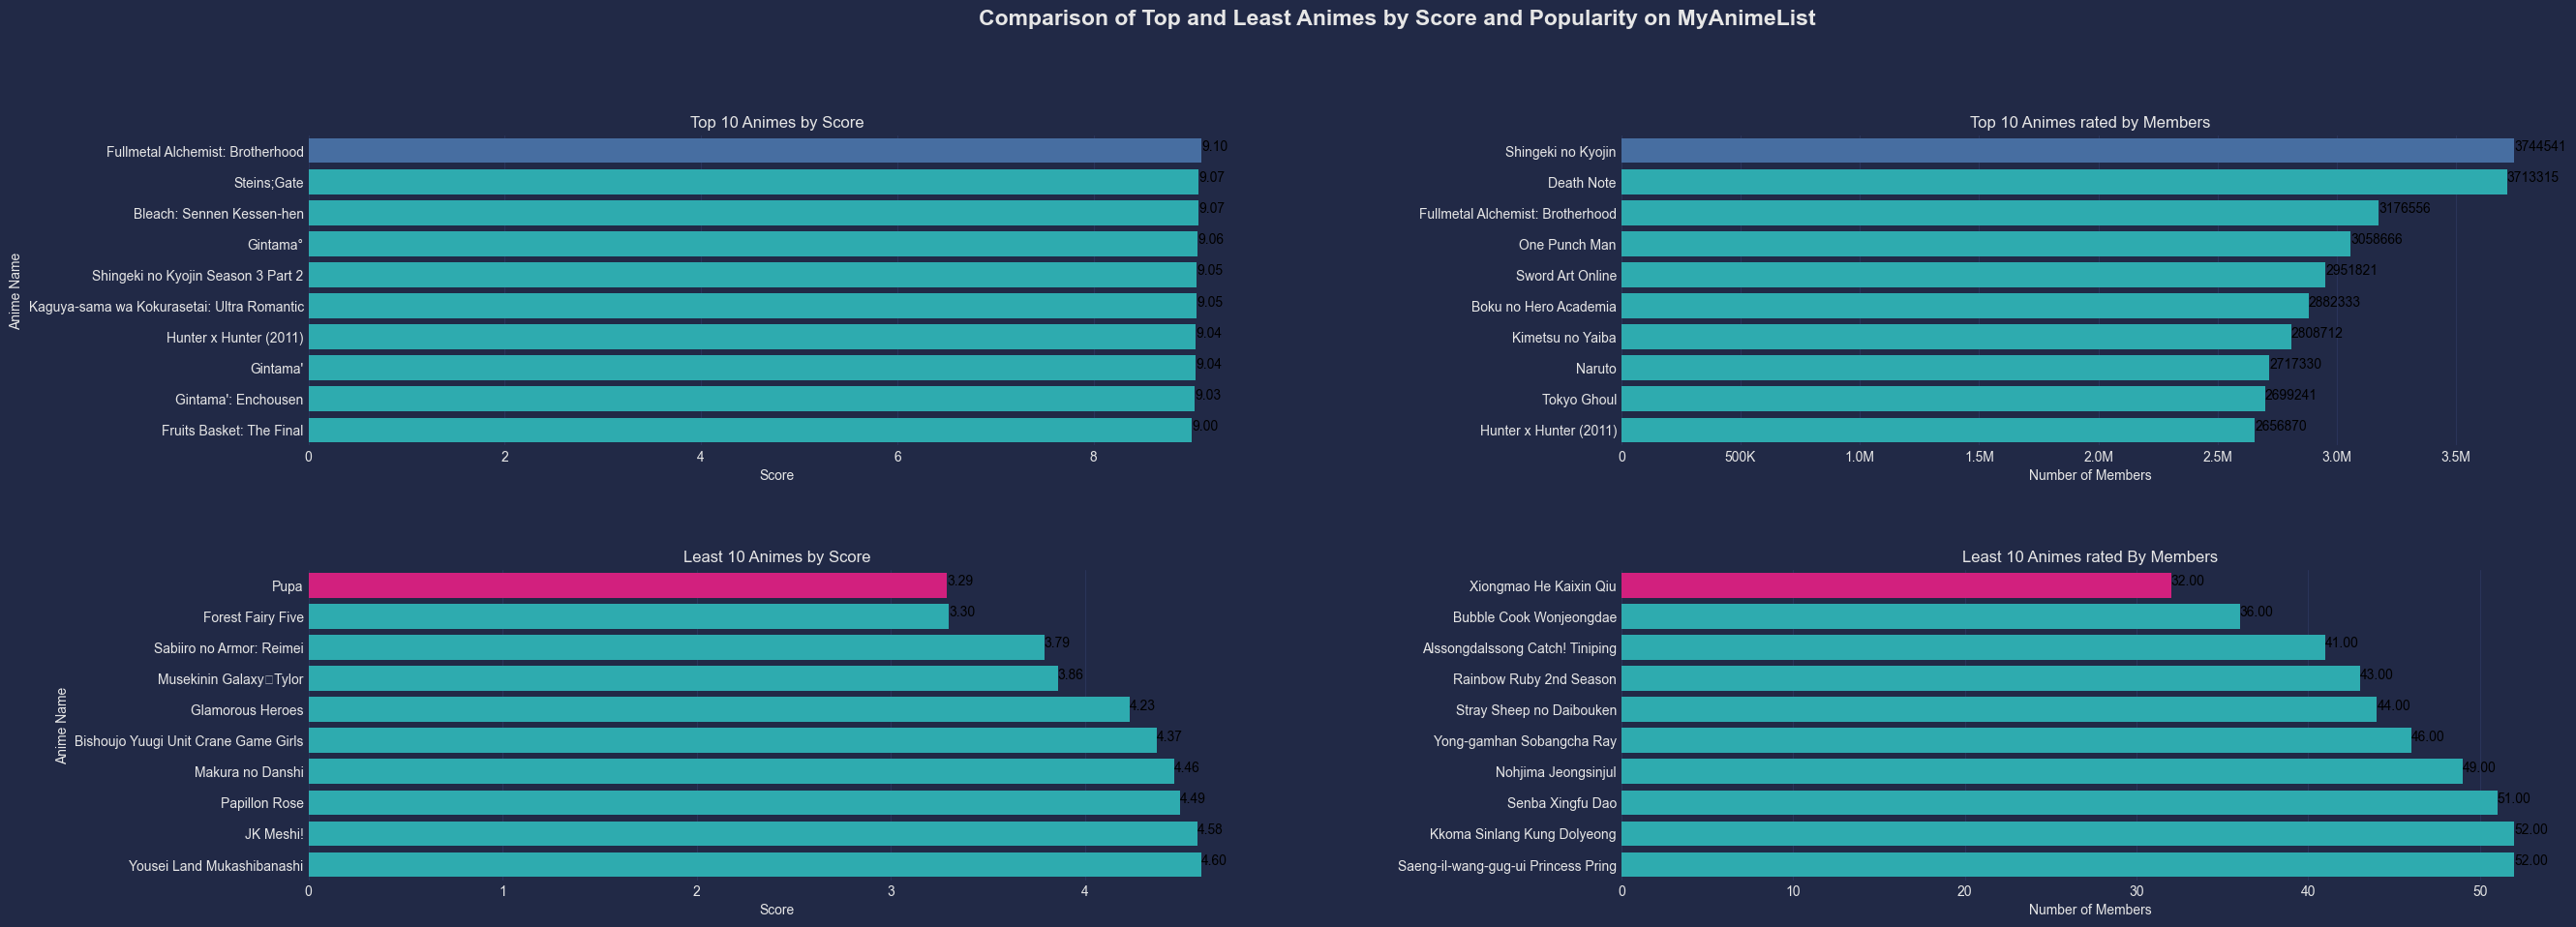

In [61]:
# -> CONVERT THE MEMBERS COLUMN TO INT 
anime['Members'] = anime['Members'].astype('int')

# Sort the DataFrame by 'Score' in descending order
top_scores = anime.sort_values(by='Score', ascending=False).head(10)
top_rated = anime.sort_values(by='Members', ascending=False).head(10)
least_scores = anime.sort_values(by='Score', ascending=True).head(10)
least_rated = anime.sort_values(by='Members', ascending=True).head(10)

formatter = FuncFormatter(million_formatter)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 10))

# Top 10 Animes by Score
barplot = sns.barplot(x='Score', y='Name', data=top_scores, ax=ax1)
ax1.set_xlabel('Score')
ax1.set_ylabel('Anime Name')
ax1.set_title('Top 10 Animes by Score')

# Highlight the longest and shortest bars
if not top_scores.empty:
    index_longest = top_scores['Score'].idxmax()
    index_shortest = least_scores['Score'].idxmin()
    for idx, bar in enumerate(barplot.patches):
        if idx == top_scores.index.get_loc(index_longest):
            bar.set_facecolor('#476EA1')  # Highlight top bar
        elif idx == least_scores.index.get_loc(index_shortest):
            bar.set_facecolor('#9f3122')  # Highlight least bar

# Add score annotations
for index, value in enumerate(top_scores['Score']):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left")

# Top 10 Animes rated by Members
barplot = sns.barplot(data=top_rated, x='Members', y='Name', ax=ax2)
ax2.set_title('Top 10 Animes rated by Members')
ax2.set_xlabel('Number of Members')
ax2.set_ylabel('')
ax2.xaxis.set_major_formatter(formatter)

# Highlight the longest and shortest bars
if not top_rated.empty:
    index_longest = top_rated['Members'].idxmax()
    index_shortest = least_rated['Members'].idxmin()
    for idx, bar in enumerate(barplot.patches):
        if idx == top_rated.index.get_loc(index_longest):
            bar.set_facecolor('#476EA1')  # Highlight top bar
        elif idx == least_rated.index.get_loc(index_shortest):
            bar.set_facecolor('#d2207e')  # Highlight least bar

# Add member annotations
for index, value in enumerate(top_rated['Members']):
    barplot.text(value, index, f'{int(value):d}', color='black', ha="left")

# Least 10 Animes by Score
barplot = sns.barplot(x='Score', y='Name', data=least_scores, ax=ax3)
ax3.set_xlabel('Score')
ax3.set_ylabel('Anime Name')
ax3.set_title('Least 10 Animes by Score')

# Highlight the longest and shortest bars
if not top_rated.empty:
    index_longest = top_rated['Members'].idxmax()
    index_shortest = least_rated['Members'].idxmin()
    for idx, bar in enumerate(barplot.patches):
        if idx == top_rated.index.get_loc(index_longest):
            bar.set_facecolor('#d2207e')  # Highlight top bar
        elif idx == least_rated.index.get_loc(index_shortest):
            bar.set_facecolor('#d2207e')  # Highlight least bar

# Add score annotations
for index, value in enumerate(least_scores['Score']):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left")

# Least 10 Animes rated by Members
barplot = sns.barplot(data=least_rated, x='Members', y='Name', ax=ax4)
ax4.set_title('Least 10 Animes rated By Members')
ax4.set_xlabel('Number of Members')
ax4.set_ylabel('')

# Highlight the longest and shortest bars
for idx, bar in enumerate(barplot.patches):
    if idx == top_rated.index.get_loc(index_longest):
        bar.set_facecolor('#d2207e')  # Highlight top bar
    elif idx == least_rated.index.get_loc(index_shortest):
        bar.set_facecolor('#d2207e')  # Highlight least bar

# Add member annotations
for index, value in enumerate(least_rated['Members']):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left")

plt.suptitle('Comparison of Top and Least Animes by Score and Popularity on MyAnimeList',
            y=1,verticalalignment='center', horizontalalignment='center' , fontsize=16.6, fontweight='bold')
plt.subplots_adjust(hspace=0.4 , wspace=0.4)




plt.show()



📍We Can see that The top scored Anime of all time is `Fullmetal Alchemist :Brotherhood` with having a score of `9.10` , while on the other hand , The most Added Anime on MyAnimeList platform is `Shingeki no kyojin (Attack on Titans)` with more than `3M` users adding it to their list . 

Another observation worth stating , While being the top Anime by `Score` , Fullmetal Alchemist seems to be the third most added anime to The users list .
 >🧐This raise up a question wether the `Score` is related to `Members` ? and does that means that `Attack on Titans` is more popular and the vise versa? 
 > To help us understand the better and answer the question , we will test the correlation visually between `Score` and Members engagment.


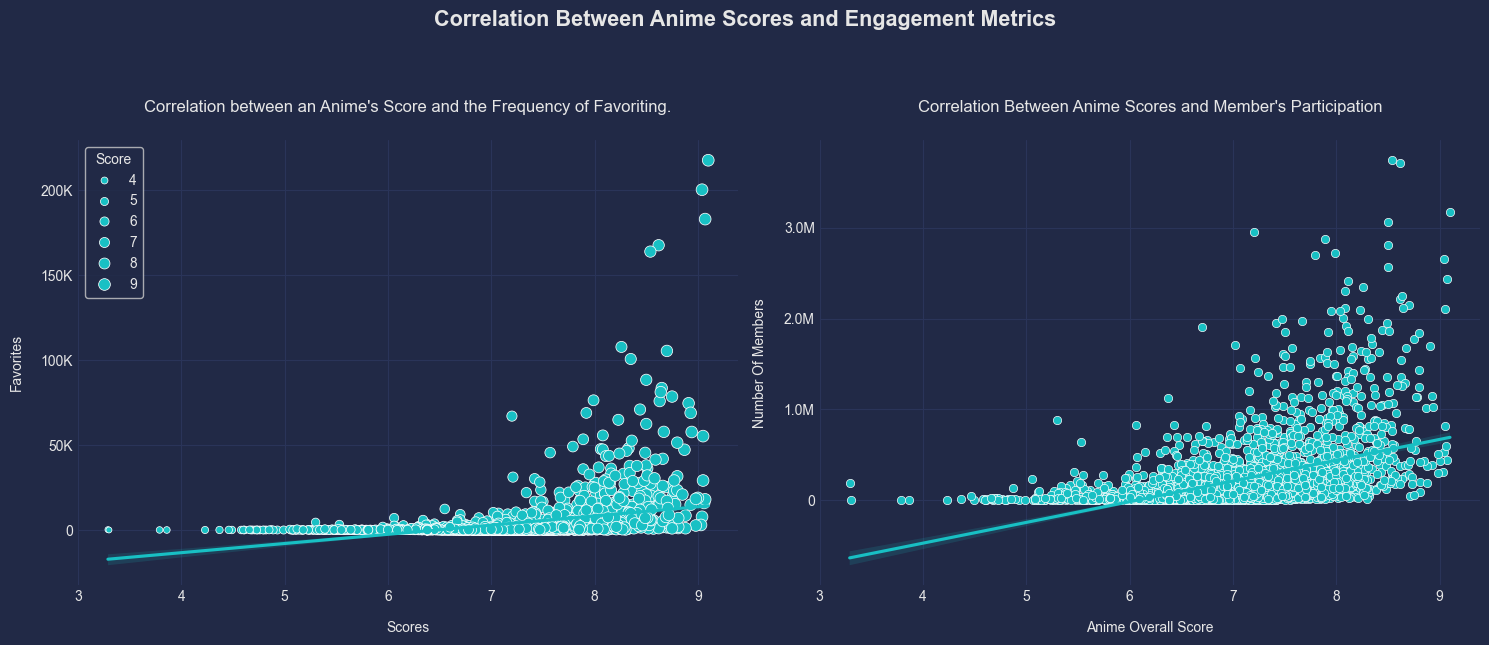

In [62]:
# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot 1 with regression line
sns.scatterplot(data=anime, x='Score', y='Favorites', ax=ax1, size='Score')
sns.regplot(data=anime, x='Score', y='Favorites', scatter=False, ax=ax1)
ax1.set_xlabel('Scores', labelpad=12)
ax1.set_ylabel('Favorites', labelpad=12)
ax1.set_title("Correlation between an Anime's Score and the Frequency of Favoriting.", pad=20)
ax1.yaxis.set_major_formatter(FuncFormatter(dynamic_formatter))

# Scatter plot 2 with regression line
sns.scatterplot(data=anime, x='Score', y='Members', ax=ax2)
sns.regplot(data=anime, x='Score', y='Members', scatter=False, ax=ax2)
ax2.set_xlabel('Anime Overall Score', labelpad=12)
ax2.set_ylabel('Number Of Members', labelpad=12)
ax2.set_title("Correlation Between Anime Scores and Member's Participation", pad=20)
ax2.yaxis.set_major_formatter(FuncFormatter(million_formatter))

# Set figure title
fig.suptitle('Correlation Between Anime Scores and Engagement Metrics',
             y=1.05, verticalalignment='center', horizontalalignment='center', fontsize=15.6, fontweight='bold')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


              Score   Members  Favorites
Score      1.000000  0.458858   0.488962
Members    0.458858  1.000000   0.783521
Favorites  0.488962  0.783521   1.000000


<Axes: >

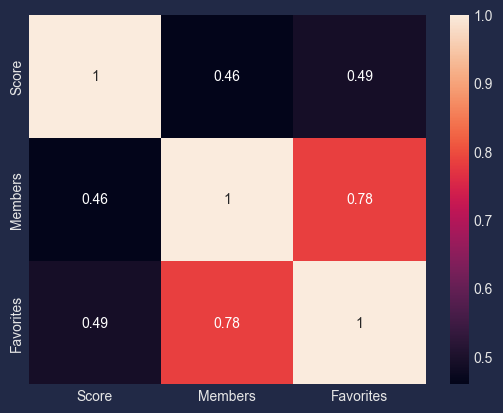

In [63]:
anime_filtered = anime[~outliers.any(axis=1)]

correlation_matrix = anime_filtered[['Score', 'Members', 'Favorites']].corr()

print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True)

>💡In addressing our inquiry, both `Favorites` and `Members` display a positive correlation with `Score.` Nonetheless, it appears that anime shows listed as favorites by users have a stronger association with score compared to other shows on MAL's list.

> #### <center>  📺TV Shows Or Movies ? 🎞️ <center/>
After inspecting The top/worst 10 Anime , We are now interested in The type of The Anime. 
 >Which Type is more popular among users ❔ 

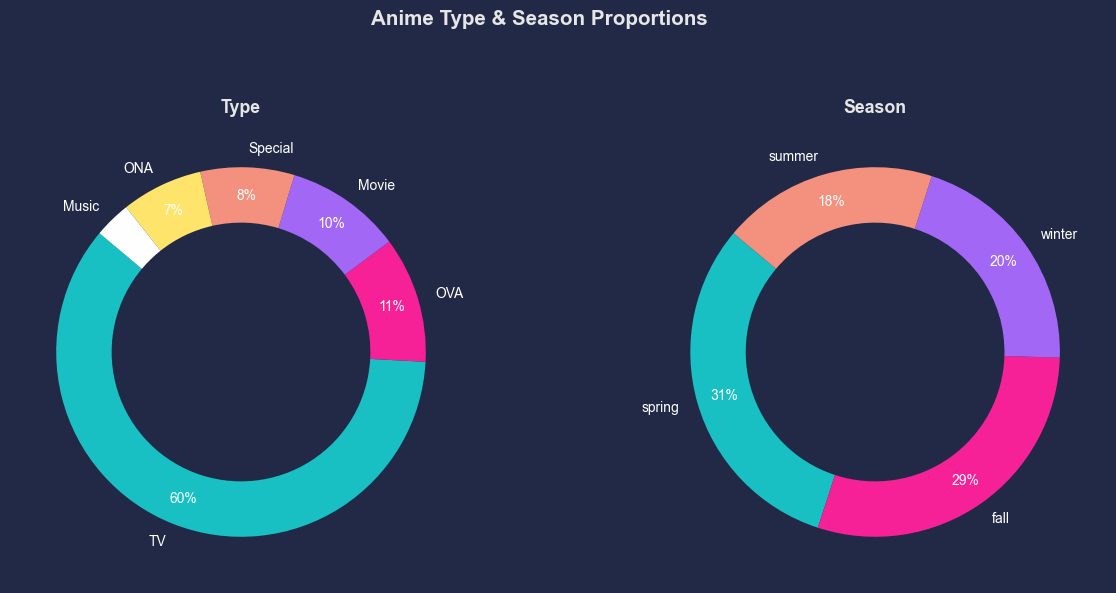

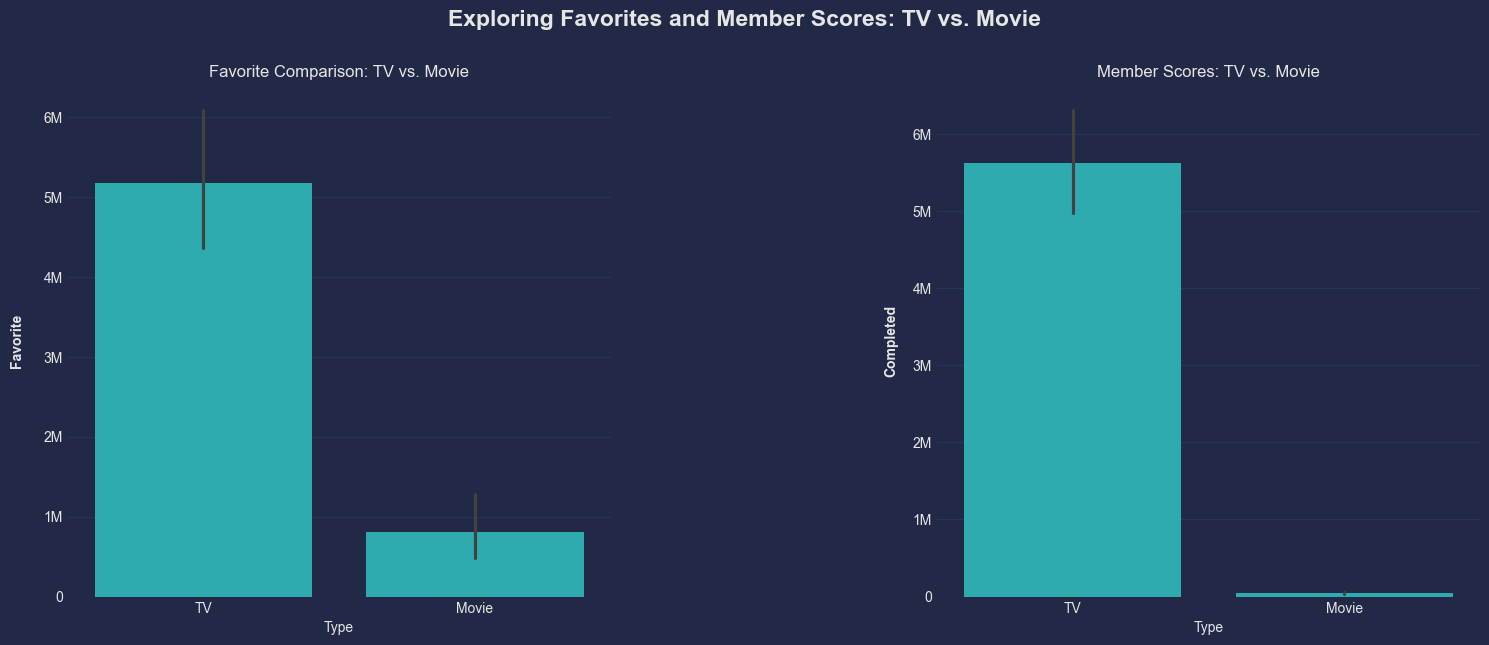

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

type_prop = anime['Type'].value_counts()
season_prop = anime['Premiered'].str.split().str[0].value_counts()

# PIE CHART FOR TYPES
type_prop.plot(kind='pie', labels=type_prop.index,autopct='%d%%', ax=ax1,pctdistance=0.85,
          startangle=140, wedgeprops=dict(width=0.3), textprops=dict(color='white')    )
ax1.set_title('Type', fontdict={'fontweight':'bold', 'size':'12.8'})
ax1.set_ylabel('')

# SEASON PIE CHART
season_prop.plot(kind='pie', labels=season_prop.index,autopct='%d%%', ax=ax2, pctdistance=0.85,
                 startangle=140,
                  wedgeprops=dict(width=0.3), textprops=dict(color="white"))
ax2.set_title('Season', font={'weight':'bold', 'size':'12.8'})
ax2.set_ylabel('')

plt.suptitle('Anime Type & Season Proportions',
              y=1.05,fontsize=14.8, fontweight='bold', verticalalignment='center',horizontalalignment='center')
plt.show()
plt.close('all')

# Filter data for TV and Movie types
tv_movie_data = anime[anime['Type'].isin(['TV', 'Movie'])]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Use 1 row and 2 columns for subplots

sns.barplot(data=tv_movie_data, x='Type', y='Favorites', estimator=sum, ax=ax1)
ax1.set_title('Favorite Comparison: TV vs. Movie')
formatter = FuncFormatter(dynamic_formatter)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Favorite', fontweight='bold', labelpad=14)

sns.barplot(data=tv_movie_data, x='Type', y='Completed', estimator=sum, ax=ax2)
ax2.set_title('Member Scores: TV vs. Movie')
ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylabel('Completed', fontweight='bold', labelpad=10.2)
plt.tight_layout()
plt.suptitle('Exploring Favorites and Member Scores: TV vs. Movie', y=1.05, verticalalignment='center',
              horizontalalignment='center', fontsize=16.6, fontweight='bold')
plt.subplots_adjust(wspace=0.6)
plt.show()



The above analysis tells us that: 
> 📺Users generally show a preference for anime shows **over** movies and tend to watch them **more frequently**. Additionally, it appears that **Spring** is the season with the highest number of anime releases.

> #### <center> 💡 Anime Genre Insights: Favorites & Popularity <center/>

After inspecting important features related to Anime **(Type, top 10 animes)** We want to explore further and analyse the Genre of anime . 
<center> 📍 Which Genre is the most popular ?<center/>
<center> 📍 Explore the Relationship between Genre and Score, which genre often gets higher scores ❔<center/>


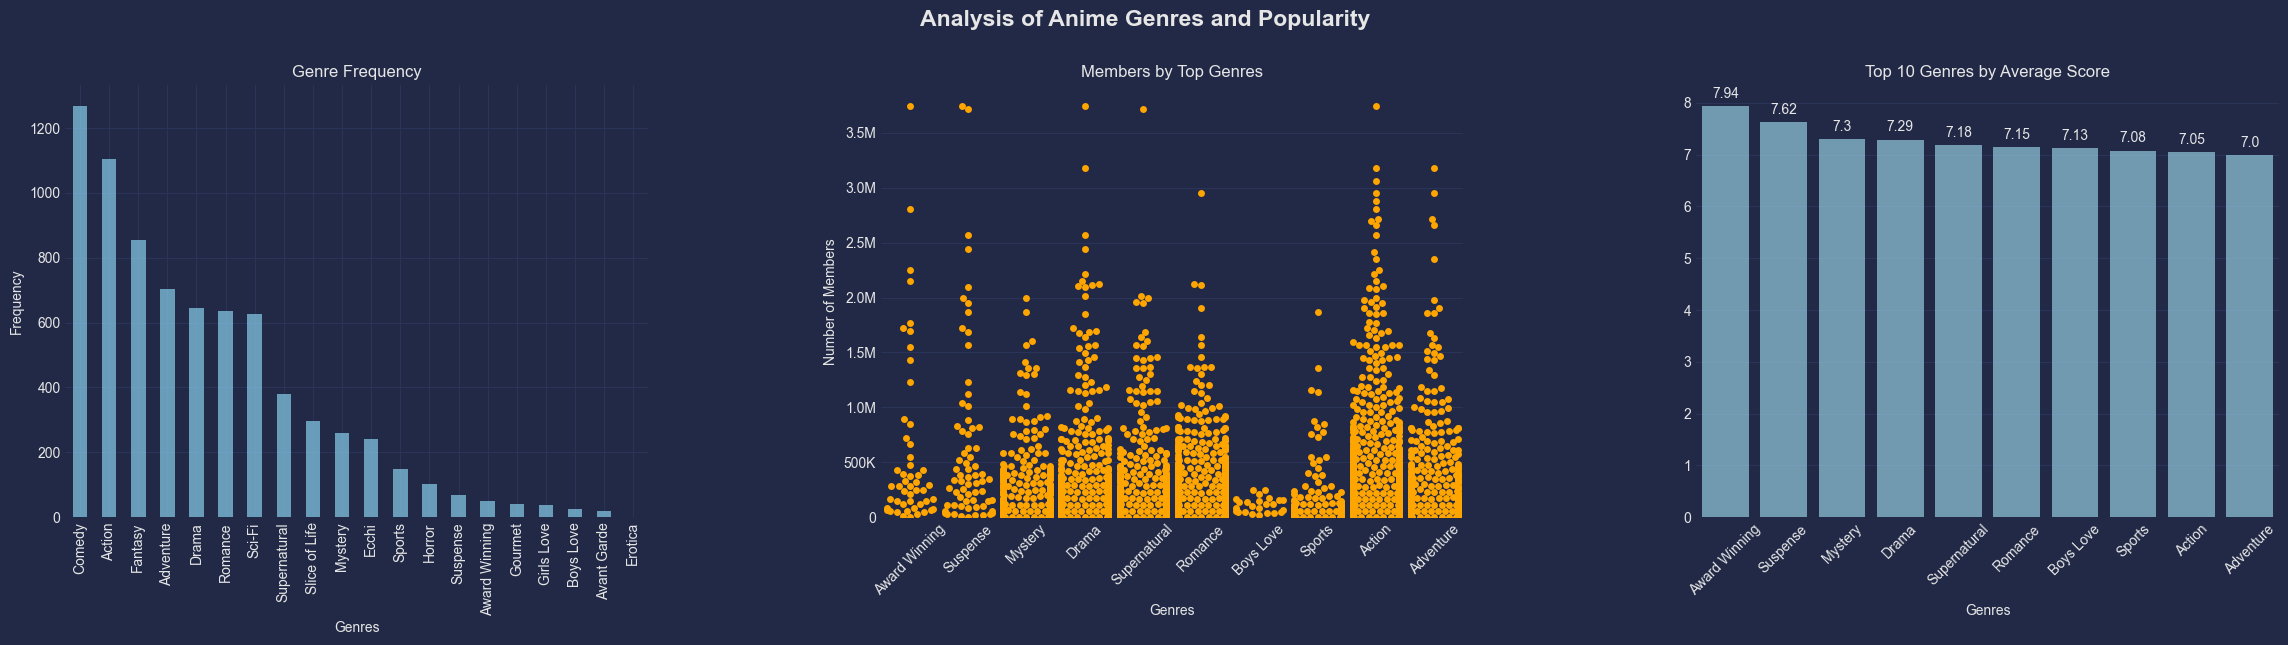

In [34]:
clean_genre = anime.dropna(subset=['Genres'])
genre_counts = clean_genre['Genres'].apply(lambda x: x.split(', ')).explode().value_counts()

# Filter top genres to exclude any labels not present in the anime DataFrame
top_genres = genre_counts.head(20)

# Calculate mean popularity for each genre in the top genres list
top_popularity = {}
for genre in top_genres.index:
    genre_popularity = clean_genre[clean_genre
                                   ['Genres'].str.contains(genre, regex=False)]['Popularity'].mean()
    top_popularity[genre] = genre_popularity

top_popularity = pd.Series(top_popularity)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(23, 6))


# ROTATE X-LABELS ON FIRST PLOT 
# Plotting Genre Frequency on the first subplot
plt.xticks(rotation=45)
genre_counts.plot(kind='bar', color='skyblue', alpha=0.7, label='Genre Frequency', ax=ax1)
ax1.set_xlabel('Genres')
ax1.set_ylabel('Frequency')
ax1.set_title('Genre Frequency')


#                                               GENRE VS SCORE
# Splitting the genres and exploding to separate rows in the copied DataFrame
clean_genre['Genres'] = clean_genre['Genres'].str.split(',')
anime_cleaned = clean_genre.explode('Genres')

# Remove leading/trailing spaces
anime_cleaned['Genres'] = anime_cleaned['Genres'].str.strip()

# Calculate mean scores for each genre in the copied DataFrame
mean_scores = anime_cleaned.groupby('Genres')['Score'].mean().sort_values(ascending=False)

# Select the top 10 genres by mean score
top_genres = mean_scores.head(10)

members_by_genre = anime_cleaned.groupby('Genres')['Members'].apply(lambda x: x.sort_values(ascending=False))


sns.barplot(x=top_genres.index, y=top_genres.values, color='skyblue', alpha=0.7,ax=ax3)
ax2.tick_params(axis='x', labelrotation=45)
ax2.set_xlabel('Genres')
ax2.set_ylabel('')

plt.title('Top 10 Genres by Average Score')
for i, v in enumerate(top_genres.values):
    plt.text(i, v + 0.1, round(v, 2), ha='center', va='bottom')
plt.tight_layout()

# Merging the 'Members' column with the top genres
merged_genres_members = pd.merge(top_genres, anime_cleaned[['Genres', 'Members']], on='Genres')

# Plotting a swarm plot
sns.swarmplot(data=merged_genres_members, x='Genres', y='Members',ax=ax2,color='orange')
formatter = FuncFormatter(million_formatter)
ax2.yaxis.set_major_formatter(formatter)
# Setting plot titles, labels, and rotation
ax2.set_title('Members by Top Genres')
ax2.set_xlabel('Genres')
ax2.set_ylabel('Number of Members')
ax2.set_ylim(bottom=0)
plt.xticks(rotation=45)



# Adjusting the vertical spacing between subplots
plt.suptitle('Analysis of Anime Genres and Popularity',
            y=1.05, verticalalignment='center', horizontalalignment='center', fontsize=16.6, fontweight='bold')

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()




>💡We notice That **Comedy , Action** are the top 2 Genres with more than 1000 animes produced in thoese Genres. In contrary , **Erotica** Genre Does not to seem to have many animes produced in that Genre. 
It is also clear that , The *MyAnimeList* members Has Added **Action** Animes the most to their list .
In terms of score , The **Award Winning** Genre logically , has the top average score , with the Genre **Suspence** second to top. 


> ### <center> 🔎 Inspecting Rating and Source 🔍<center/>
<center> Below, we will inspect the distribution of Anime Ratings and Source to give us more information about The production of animes in both categories . <center/>

C:\Users\WinDows\AppData\Local\Temp\ipykernel_20676\337152991.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=9)


Text(0.5, 1.02, 'Analyzing Anime Ratings and Popular Source')

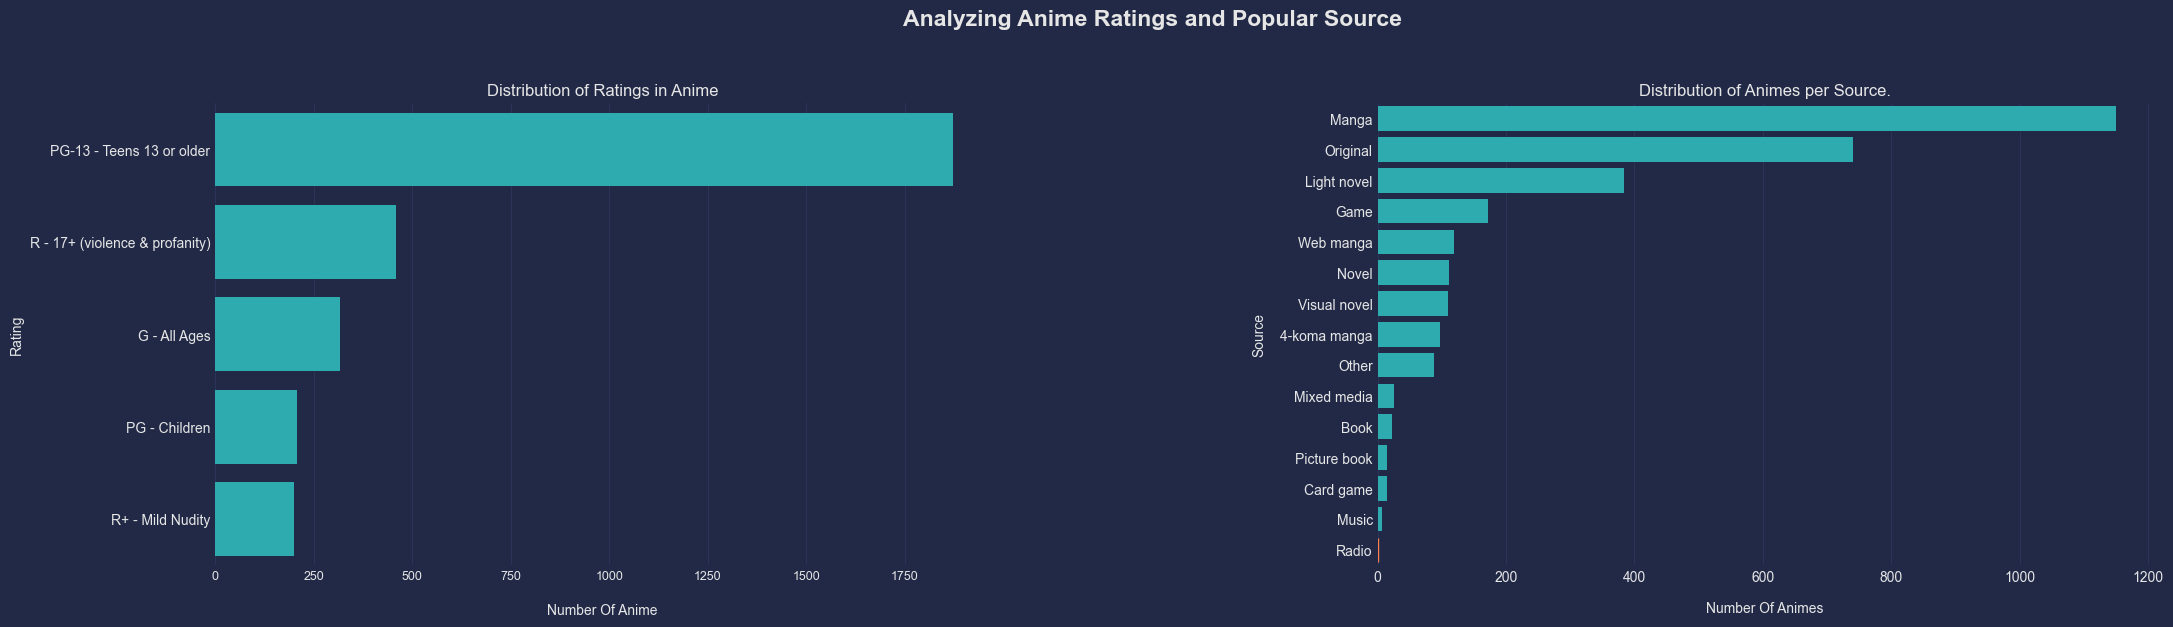

In [26]:
# Sorting the data by the count of occurrences in descending order
filtered_source = anime[anime['Source'] != "Unknown"]
filtered_rating = anime[anime['Rating'] != 'UNKNOWN']

sorted_counts_anime = filtered_rating['Rating'].value_counts().sort_values(ascending=False)
sorted_counts_source = filtered_source['Source'].value_counts().sort_values(ascending=False)

# Get the top and bottom values for both plots
top_anime = sorted_counts_anime.index[0]
bottom_anime = sorted_counts_anime.index[-1]

top_source = sorted_counts_source.index[0]
bottom_source = sorted_counts_source.index[-1]

# Creating the bar plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

# Bar plot for Ratings
sns.countplot(data=filtered_rating, y='Rating', ax=ax1, order=sorted_counts_anime.index)
ax1.set_xlabel('Number Of Anime', labelpad=15)
ax1.set_ylabel('Rating')
ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=9)
ax1.set_title('Distribution of Ratings in Anime')


# Bar plot for Sources
sns.countplot(data=filtered_source, y='Source', ax=ax2, order=sorted_counts_source.index)
ax2.set_xlabel('Number Of Animes', labelpad=12)
ax2.set_ylabel('Source', labelpad=10)
ax2.set_title('Distribution of Animes per Source.', y=1)

# Highlight the lowest value bar with a different color
for idx, bar in enumerate(ax2.patches):
    if sorted_counts_source.index[idx] == bottom_source:
        bar.set_color('coral')
plt.subplots_adjust(wspace=0.5)
# Set the title for the entire figure
plt.suptitle('Analyzing Anime Ratings and Popular Source',
             y=1.02, verticalalignment='center',fontweight='bold', fontsize=16.6 )


>We can see that in terms of Anime `Soruce` : <br> <br/>
    Manga is the most popular with almost 1200 animes produced , while on the other hand , Radio is almost invesible in the graph for having the smallest number of anime produced 

>As for the Anime `Ratings` , we can see that :<br><br/>
     PG-13 is the domeninet Rating in the anime industry with more than 1750 anime produced in that rating , in contrary , R+ has only less than 200 anime produced in the rating . 


> #### <center> Analyzing Studios : Does Studio Actually Matter 👀 ? <center/>
<center> We will explore the ditribution of production studios , and we will explore the  top 15 production studios with the highest average score <center/>

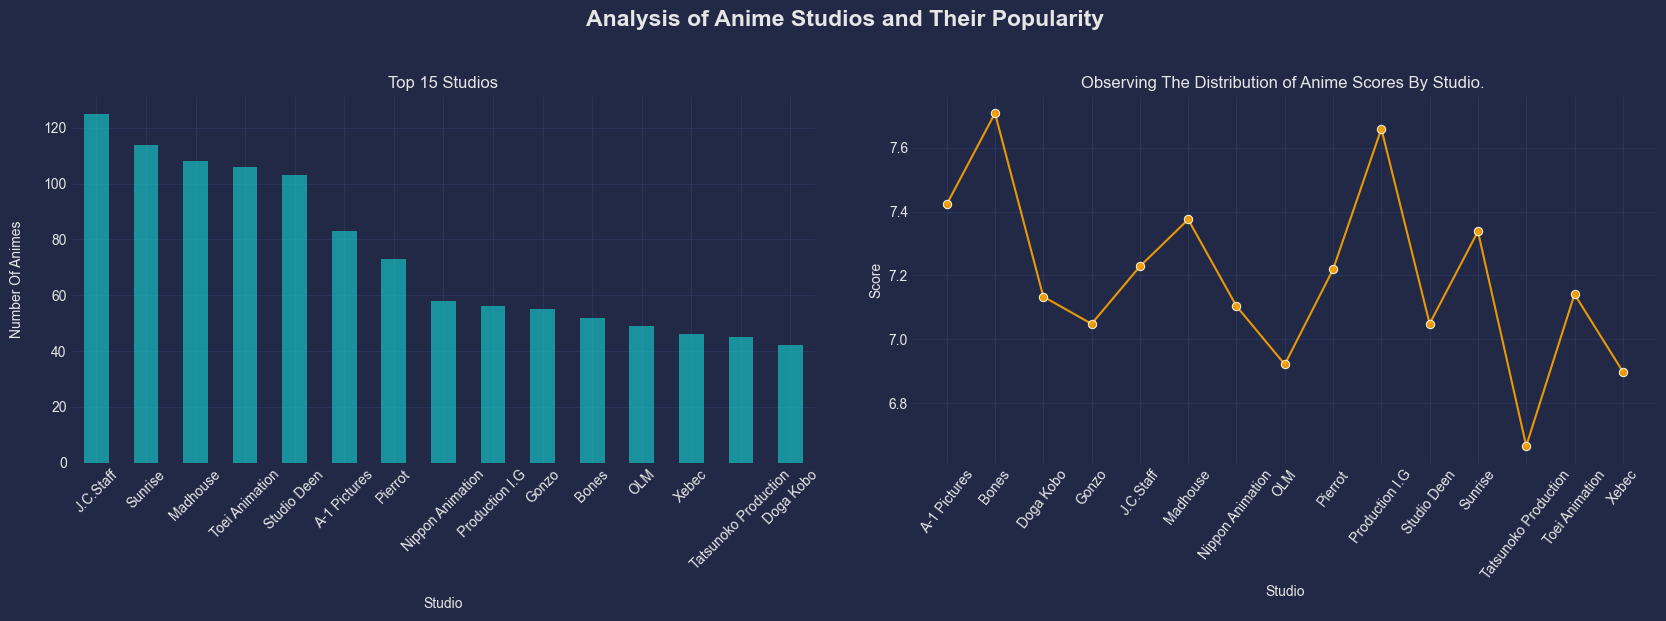

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))

Studios = anime['Studios'].value_counts().drop_duplicates()
Studios = Studios[Studios.index != 'UNKNOWN']
top_15_studios = Studios.head(15)



top_15_studios.plot(kind='bar', ax=ax1, alpha=0.7)  # Plotting the top 15 studios directly
#plt.xticks(rotation=90)
ax1.set_xlabel('Studio', labelpad=18)
ax1.set_ylabel('Number Of Animes', labelpad=14)
ax1.set_title('Top 15 Studios')
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()

studio_popularity = anime.groupby('Studios')['Score'].mean().reset_index()
studio_popularity_filtered = studio_popularity[studio_popularity['Studios'].isin(top_15_studios.index)]

sns.lineplot(data=studio_popularity_filtered, x='Studios', y='Score', color='orange', marker='o', alpha=0.9)
plt.xticks(rotation=52)
ax2.set_title('Observing The Distribution of Anime Scores By Studio. ')
ax2.set_xlabel('Studio', labelpad=2.5)
ax2.set_ylabel('Score', labelpad=4)
plt.suptitle('Analysis of Anime Studios and Their Popularity',
            y=1.01, verticalalignment='center', horizontalalignment='center', fontsize=16.6, fontweight='bold')

plt.subplots_adjust(wspace=10)
plt.tight_layout()

plt.show()


>The graph above indicates that although `J.C. Staff` Studio produces the highest number of anime, with an average score of approximately 7.2 for their productions (which is not the highest), `Bones` Studio, despite producing only around 60 anime, achieves an average score of approximately 7.9 for their works.

>### <center>Exploring Anime Production Trends Over Time: A Historical Perspective 🕰️<center/>
<center> - Let's delve into the distribution of anime production across years and decades. 📊<center/>
<center> - Additionally, we'll examine the production trends of specific types of anime over time to uncover any discernible patterns. 🔎<center/>
<center> - Finally, we'll conduct a comparative analysis of anime scores throughout the decades. 🌟<center/>


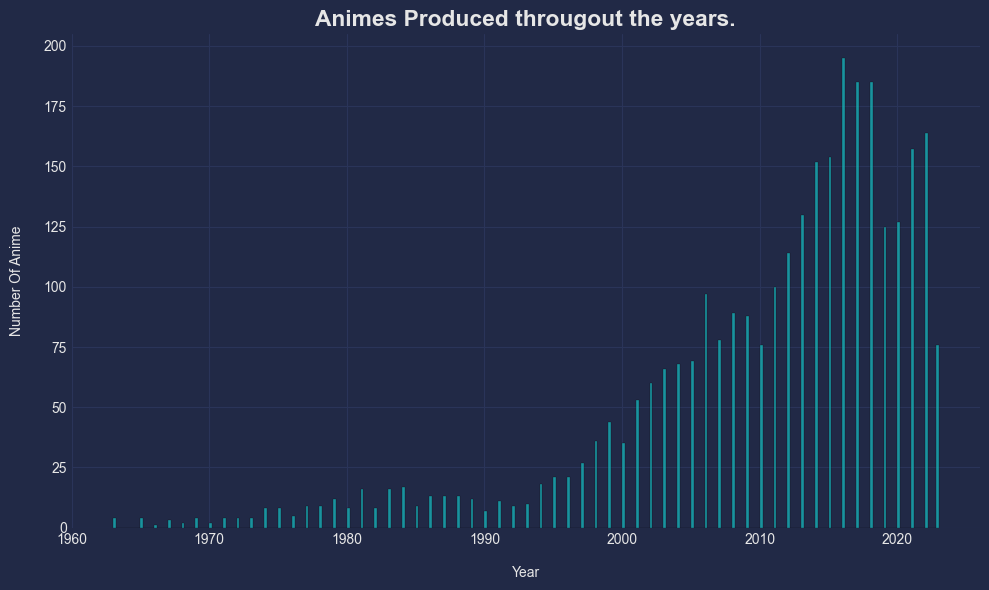

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=anime , x='Aired-Year', element='bars',alpha=0.7, bins=300)
plt.title('Animes Produced througout the years.', fontsize=16.4, fontweight='bold')
plt.xlabel('Year', labelpad=14)
plt.ylabel('Number Of Anime', labelpad=14)
plt.tight_layout()

plt.show()

> It seems that overall, the number of anime being made increased over time until around 2010 when there was a downturn. However, after 2010, anime production picked up again until the pandemic hit, causing another decline.

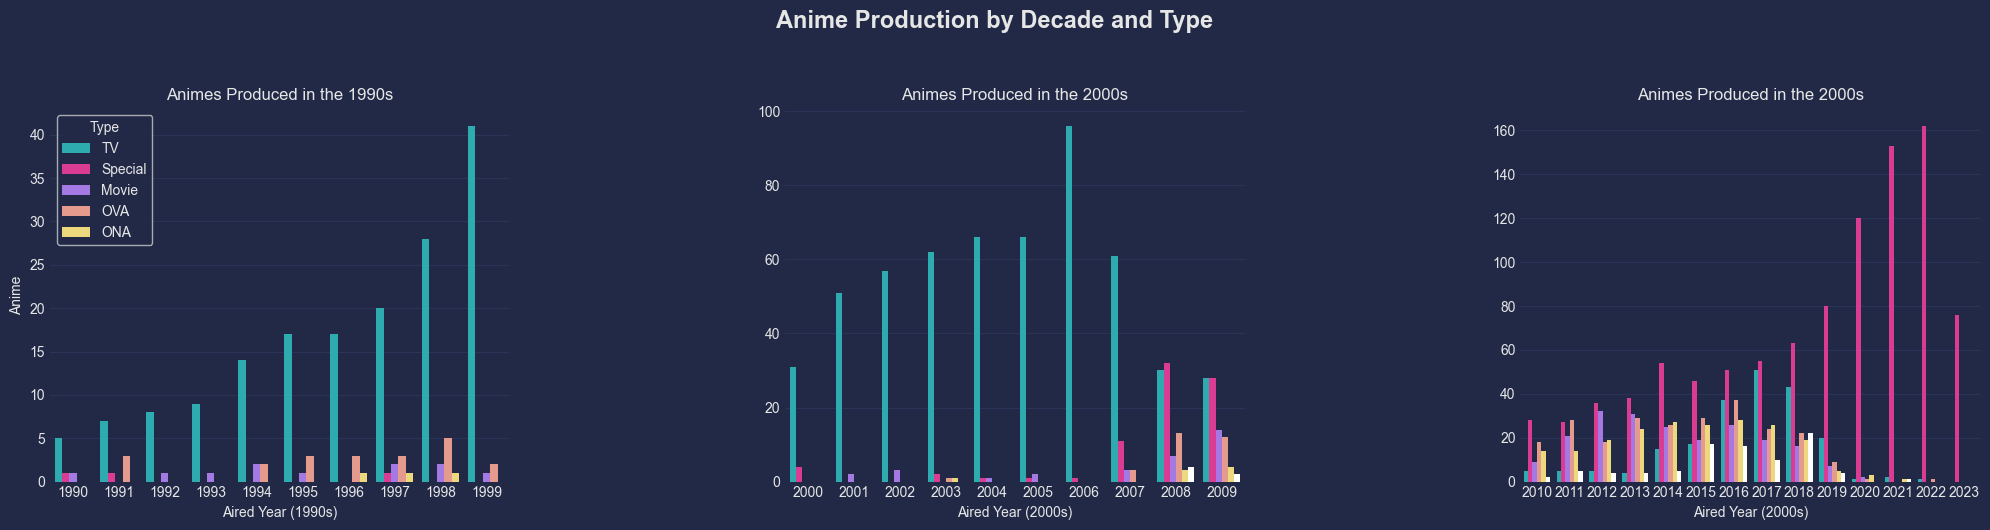

In [29]:
anime_90s = anime[anime['Aired-Year'].between(1990, 1999)]
anime_2000s = anime[anime['Aired-Year'].between(2000, 2009)]
anime_2010s = anime[anime['Aired-Year'].between(2010,2023)]
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 5))


# Plot for the '90s
sns.countplot(data=anime_90s, x='Aired-Year', ax=ax1, hue='Type')
ax1.set_xlabel('Aired Year (1990s)')
ax1.set_ylabel('Anime')
ax1.set_title('Animes Produced in the 1990s')

# Plot for the '2000s
sns.countplot(data=anime_2000s, x='Aired-Year', ax=ax2, hue='Type')
ax2.set_xlabel('Aired Year (2000s)')
ax2.set_ylabel('Count of Animes')
ax2.set_title('Animes Produced in the 2000s')
ax2.legend().remove()
ax2.set_ylabel('')

sns.countplot(data=anime_2010s, x='Aired-Year', ax=ax3, hue='Type')
ax3.set_xlabel('Aired Year (2000s)')
ax3.set_ylabel('Count of Animes')
ax3.set_title('Animes Produced in the 2000s')
ax3.legend().remove()

ax3.set_ylabel('')

fig.suptitle('Anime Production by Decade and Type', fontsize=17 , fontweight='bold', y=1.05)
plt.tight_layout()
plt.subplots_adjust(wspace=0.6, hspace=0.9)
plt.show()



>As mentioned before, anime production steadily rose over the decades. During the early 1990s, `OVA`s and `specials` were scarcely seen until the 2020s when specials became prevalent in the industry. `Movies` consistently had lower production rates.

C:\Users\WinDows\AppData\Local\Temp\ipykernel_20676\380130115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_animes_80s_to_2012['Aired-Year'] = top_animes_80s_to_2012['Aired-Year'].astype(int)


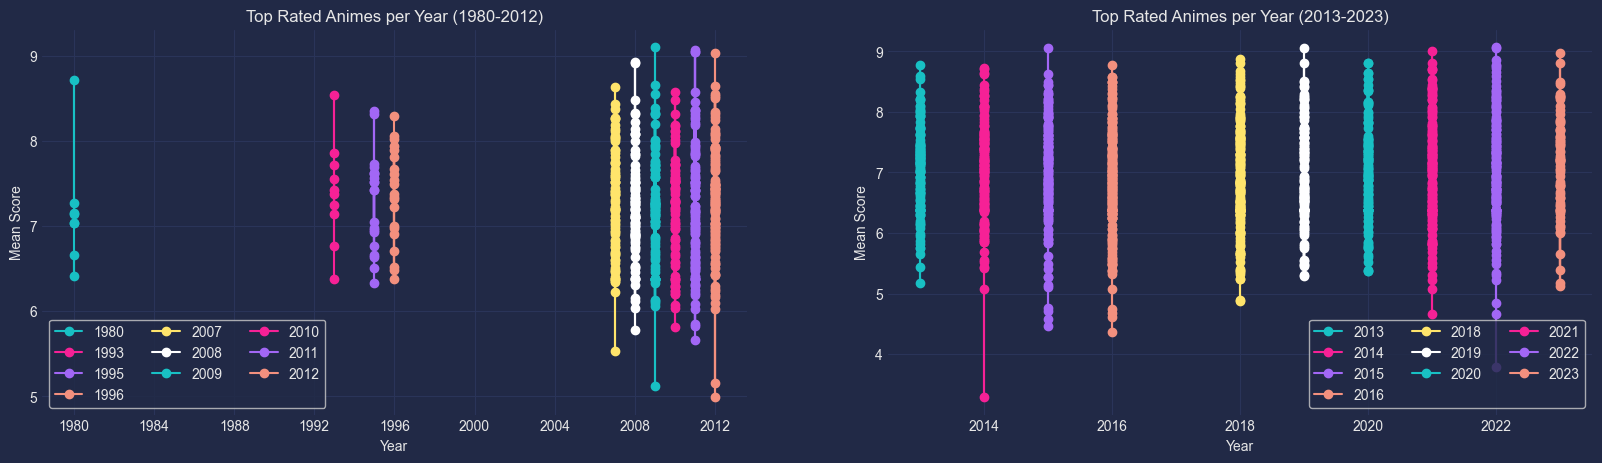

In [30]:
# Filter the anime data for the specified year ranges
top_animes_80s_to_2012 = anime[(anime['Aired-Year'] >= 1980) & (anime['Aired-Year'] <= 2012)]
top_animes_80s_to_2012['Aired-Year'] = top_animes_80s_to_2012['Aired-Year'].astype(int)
top_animes_2013_to_2023 = anime[(anime['Aired-Year'] >= 2013) & (anime['Aired-Year'] <= 2023)]


# Group by 'Aired-Year' and calculate mean score for each year
mean_scores_80s_to_2012 = top_animes_80s_to_2012.groupby('Aired-Year')['Score'].mean().nlargest(10)
mean_scores_2013_to_2023 = top_animes_2013_to_2023.groupby('Aired-Year')['Score'].mean().nlargest(10)

# Create separate plots for each range of years
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))



# Plot for years 1980-2012
for year, data in top_animes_80s_to_2012.groupby('Aired-Year'):
    if year in mean_scores_80s_to_2012:
        ax1.plot(data['Aired-Year'], data['Score'], marker='o', linestyle='-', label=year)

ax1.set_xlabel('Year')
ax1.set_ylabel('Mean Score')
ax1.set_title('Top Rated Animes per Year (1980-2012)')
ax1.legend(ncol=3)
ax1.grid(True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))


# Plot for years 2013-2023
for year, data in top_animes_2013_to_2023.groupby('Aired-Year'):
    if year in mean_scores_2013_to_2023:
        ax2.plot(data['Aired-Year'], data['Score'], marker='o', linestyle='-', label=year)


ax2.set_xlabel('Year')
ax2.set_ylabel('Mean Score')
ax2.set_title('Top Rated Animes per Year (2013-2023)')
ax2.legend(ncol=3)
plt.grid(True)
plt.show()


> The data suggests that as the years progress, anime tend to receive higher scores. Particularly, there has been a noticeable increase in the number of highly-rated anime during the 2010s and 2020s. Moreover, from around 2007 onwards, there has been a significant rise in the occurrence of anime receiving scores of 9 and above, indicating an upward trend in the quality of productions during this period.


> ### <center>  🧐Testing Correlation and relations 🔄️ <center/>
 <center>After getting insights on our data we now know the distibution , and most variables . next , we need to relate these variables and test the relationship if exisits <center/>
  <center>we will be exploring relationships such as :<center/><br><br/>
   <center> -  user engagment vs score (are they related?) <center/>
     <center> -  Genre and score , how do they relate to each other ? <center/>
      <center>  -  is ranking equals score and the vice versa ? or not?<center/>
  

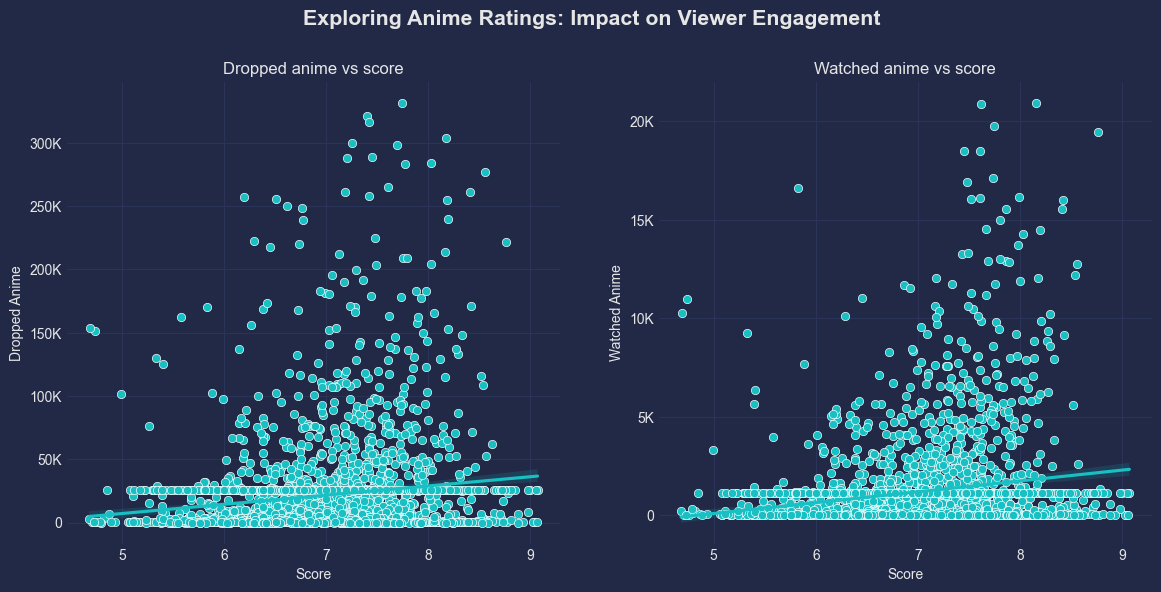

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Episodes', 'Premiered', 'Status', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Rank', 'Popularity',
       'Favorites', 'Scored By', 'Members', 'Image URL', 'Watching',
       'Completed', 'On-Hold', 'Dropped', 'Type', 'Aired-Year'],
      dtype='object')

In [38]:
# Sort the DataFrame by 'Score' in descending order and select the top-rated entries
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

sns.scatterplot(data=anime_filtered, x='Score', y='Dropped', ax=ax1)#, hue='Score')
sns.regplot(data=anime_filtered, x='Score', y='Dropped', scatter=False, ax=ax1)
ax1.set_xlabel('Score')
ax1.set_ylabel('Dropped Anime')
ax1.set_title('Dropped anime vs score')
formatter = FuncFormatter(dynamic_formatter)
ax1.yaxis.set_major_formatter(formatter)


sns.scatterplot(data=anime_filtered,x='Score', y='Completed', ax=ax2)
sns.regplot(data=anime_filtered, x='Score', y='Completed', scatter=False, ax=ax2)
ax2.set_ylabel('Watched Anime')
ax2.set_title('Watched anime vs score')
formatter = FuncFormatter(dynamic_formatter)
ax2.yaxis.set_major_formatter(formatter)

fig.suptitle('Exploring Anime Ratings: Impact on Viewer Engagement', fontsize=15.4, fontweight='bold', y=1.0)

plt.show()
anime.columns


The scatterplot reveals intriguing findings. It suggests a potential weak-positive correlation between both the number of times an anime was completed  and its score, as well as between the frequency of an anime being dropped from users' lists and its score. 


>💡*While we typically anticipate a negative relationship between`Dropped` and `Score` it's important to consider instances where users may finish watching a show but still drop it from their list. This action doesn't necessarily imply that the user disliked the anime.*
---

Scatter plots are a great way to visualize the slope of a linear relationship 
but they alone do not suffice. Therefore, we will employ the Spearman correlation test to  evaluate the relationship between our variables. ⬇️

Correlation Matrix:            Completed   Dropped     Score
Completed   1.000000  0.912695  0.127539
Dropped     0.912695  1.000000  0.131414
Score       0.127539  0.131414  1.000000


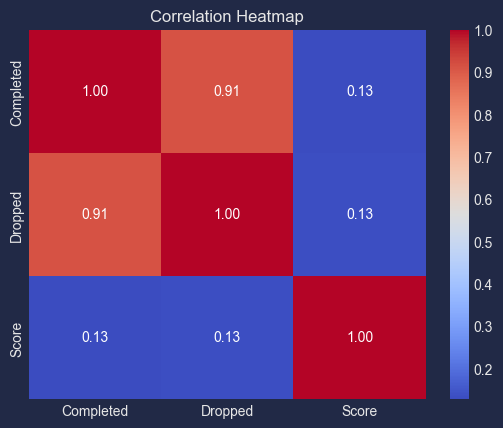

In [39]:
correlation_matrix = anime_filtered[['Completed', 'Dropped' , 'Score']].corr(method='spearman')

print(f'Correlation Matrix: {correlation_matrix}')

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


The correlation test reveals weak positive correlations between the "Score" of an anime and both the number of times it's been "Completed" and "Dropped." However, there's a strong positive correlation between "Dropped" and "Completed" counts, *indicating that users tend to drop an anime after completing it, supporting our earlier suspicion.*

---


> <center> Genre vs Score Relationship <center/>
 1. <center>we will conduct an Analysis of Variance `(ANOVA) test` to investigate differences in average scores and popularity (number of members) across different genres. <center/>
 2. <center>we will perform `Tukey's Honestly Significant Difference (HSD) test` as a post-hoc analysis to identify specific genre pairs with significantly different means for "Score" and "Members." <center/>

><center>🧐Through these tests, we are aiming to understand how anime genres relate to their scores and popularity on `MAL`.**<center/>

In [42]:
from scipy.stats import f_oneway
CategoryGroupLists=anime.groupby('Genres')['Score'].apply(list)

# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value &gt; 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults)

import statsmodels.api as sm
from statsmodels.formula.api import ols


# Fit the ANOVA model
model = ols('Score ~ Genres', data=data).fit()

# Perform Tukey's HSD test
tukey_result = sm.stats.multicomp.pairwise_tukeyhsd(data['Score'], data['Genres'])

# Print the results
print(tukey_result)


P-Value for Anova is:  F_onewayResult(statistic=2.3617741581476084, pvalue=5.3715284666705166e-42)
                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
               group1                              group2               meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------------------------------------
 Action, Adventure, Comedy, Fantasy            Action, Adventure, Drama      1.6 0.9999 -3.0838 6.2838  False
 Action, Adventure, Comedy, Fantasy   Action, Adventure, Drama, Fantasy    -1.11    1.0 -5.1663 2.9463  False
 Action, Adventure, Comedy, Fantasy          Action, Adventure, Fantasy  -0.0867    1.0  -3.664 3.4906  False
 Action, Adventure, Comedy, Fantasy           Action, Adventure, Sci-Fi     0.64    1.0 -4.0438 5.3238  False
 Action, Adventure, Comedy, Fantasy             Action, Comedy, Fantasy    -0.02    1.0 -4.0763 4.0363  False
 Action, Adventure, C

Based on the results of the Tukey HSD test:

The majority of comparisons between different genres show **no significant difference** in means for both `Score` and `Members.`
There are no significant differences in means between most genre pairs, as indicated by the "reject" column showing "False" for the majority of comparisons.

This suggests that the genres examined do not have a significant impact on the average `Score` or `Members` count of anime within those genres.

> **Overall, these findings imply that the choice of genre may not strongly influence the popularity or user ratings of anime on the MAL platform.**

>#### <center> Analyzing Relationships: Anime Rankings, Viewer Ratings, and Popularity Trends 💯 <center/>

###### <center> Diving into our last analysis for this section , we will test the correlation between `Rank` , `Score` , `Scored BY` to see how a user's scoring affect the overall popularity of a specific anime. <center/>

               Rank     Score  Scored By
Rank       1.000000 -0.996308  -0.521545
Score     -0.996308  1.000000   0.529081
Scored By -0.521545  0.529081   1.000000


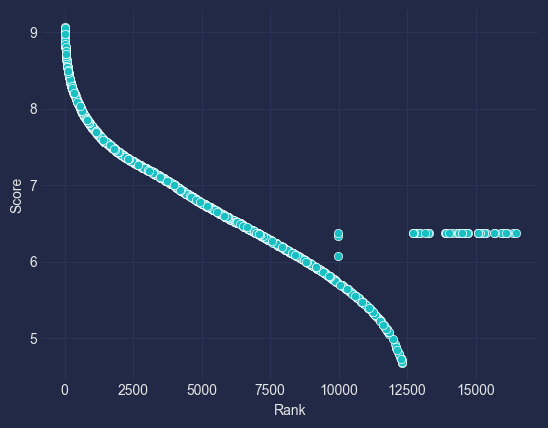

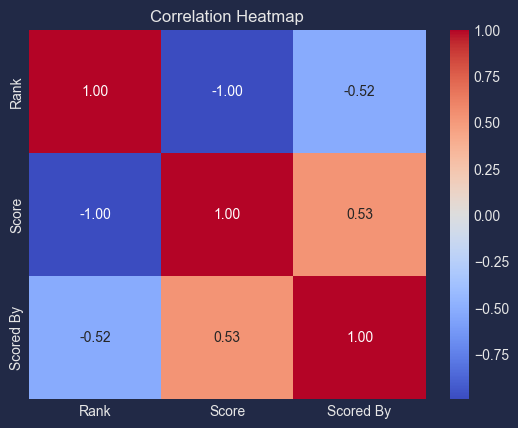

In [40]:
# Calculate Pearson correlation matrix
correlation_matrix = anime_filtered[['Rank', 'Score', 'Scored By']].corr(method='spearman')

# Output correlation matrix
print(correlation_matrix)


sns.scatterplot(data=anime_filtered, x='Rank', y='Score')
plt.show()
plt.close('all')
# Plotting the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()




>The correlation test above reveals that there is a strong negative correlation between `Rank` and `Score` suggesting that a higher score does not guarantee a higher rank for an anime. Additionally, the test indicates a positive relationship (0.53) between `Score` and `Scored By` implying that the number of users scoring the anime influences its overall score.
---

> ### <center> Conclusion and Findings 👩‍💻 <center/>

In this first section of the project, we delved into the analysis of anime data from the `MyAnimeList` website to gain insights into the industry. We divided our analysis into several steps:

**🤽‍♂️Data Preparation:**
   - We started by loading and merging data from two CSV files, cleaning the data by handling data types and null values.

**📊Visualization:**
- We visualized the data to answer our main questions. Firstly, we identified the top 10 rated anime and compared them with the top 10 most added anime to users' lists. Additionally, we explored the popularity of anime shows versus movies.

**📉Correlation Analysis:**
- We conducted correlation tests to investigate relationships between variables. Notably, we found a negative correlation between rank and score, indicating that higher scores do not necessarily result in higher rankings. Moreover, we observed a positive correlation between the overall score of anime and the number of times they were added to users' lists, though the relationship was not strong.

**🔬Insights:**
- Our analysis also revealed insights into popular genres, with action and comedy being prominent in both production numbers and overall scores.

> <center>💡Overall, our analysis sheds light on various aspects of the anime industry, providing valuable insights for further exploration. In the next section, we will shift our focus to analyzing user behavior on the platform to complement our understanding of the anime landscape.<center/>




